# Notebook for Plotting The AI Data With Dicom Plots

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import Normalize
import numpy as np, os, pandas as pd
from glob import glob
import os
import scipy
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error

In [2]:
plt.style.use('plotting_style_sheet.txt')

In [79]:
files = sorted(glob("./../neural_nets/JuliaOutputs/OptimizedRuns/Run001R2-980/fullSimulationOutputs/*"))

In [81]:
files2 = sorted(glob("./../neural_nets/JuliaOutputs/OptimizedRuns/Run000R2-980/fullSimulationOutputs/*"))

In [83]:
files3 = sorted(glob("./../neural_nets/JuliaOutputs/RubinRuns/Run000R2-944/fullOhioOutputs/*"))

In [ ]:
files4 = sorted(glob("./../neural_nets/JuliaOutputs/tegan_runs/"))

## Finding Error

### Generates lists of all input files

In [3]:
long_6 = sorted(glob('dicoms/6MV_results/longitude/*'))
long_10 = sorted(glob('dicoms/10MV_results/longitude/*'))
dicom_files = long_6.copy()
dicom_files.extend(long_10) # To get the ordering correct 6 then 10

ohio_files = sorted(glob('../neural_nets/JuliaOutputs/OptimizedRuns/Run001R2-950/fullOhioOutputs/*'))

In [4]:
def gen_ai_axis():
    return np.arange(1, 9, 1)*4.8-2.4 # Depth in mm of the bars in real space

In [5]:
def ohio_cleaning(file_list):
    '''Removes the 2.5 MeV runs from the ohio output files by removing the runs that have 8-13 in the filename'''
    
    numbers_to_aviod = list(range(8, 14))
    for file in file_list.copy():
        name = file.rstrip('.txt')
        number = int(name[-3:])
        if number in numbers_to_aviod:
            file_list.remove(file)
    return file_list

In [6]:
def dicom_depth():
    '''Returns a list containing the depth values for the points we want in the dicom distribution.
    Essentially calculates the nearest even integer for each value in ai_axis.'''
    
    depth_in_dicom = list()
    ai_xaxis = gen_ai_axis()

    for number in np.around(ai_xaxis).astype(int):
        if number % 2 == 0:
            depth_in_dicom.append(number)
        else:
            depth_in_dicom.append(number + 1)
    return depth_in_dicom

In [7]:
def ohio_energy_finder(ohio_run_file):
    '''Calculates the longitudinal energy deposition of each vertical plane of numbers. Returns an 8 number array.'''
    
    result = np.loadtxt(ohio_run_file).reshape((8,8,8)).sum(0).sum(1) 
    return result

In [8]:
def dicom_energy_finder(dicom_file):
    '''Opens the dicom dataframe file given as anargument. It uses the dicom depth list generated in function.
    The list contains the closest depth values in the dicom that correspond to the detector. It opens up the dataframe
    and iterates though the dpeth list finding the gray_value that goes with that depth and adds it to a list.'''

    df = pd.read_csv(dicom_file)
    deposition_at_depth = list()
    for depth in dicom_depth():
        deposition_at_depth.append(df[(df['Distance_(mm)'] == depth)]['Gray_Value'].values[0])
    return deposition_at_depth

In [9]:
def normalize(input_array):
    '''Normalizes the input_array to values between 0 and 1. It is expecting a numpy array'''
    input_array + 1e-10
    max_value = input_array.max()
    
    #input_array /= input_array.max()
    return input_array/max_value

In [10]:
def gen_filename(dicom_file, ohio_file):
    dicom = os.path.basename(dicom_file).rstrip('.csv')
    ohio = os.path.basename(ohio_file).rstrip('.txt')
    
    filename = '_error_' + ohio + '.pdf'
    return filename

In [11]:
def calculate_error(dicom_file, ohio_file):
    '''Calculates the error between the AI prediction and dicom distribution. 
    This returns a numpy array where each value goes with the flipped Ohio Data.
    The error is percent error. abs( [measured - true]/true )'''

    dicom_energies = np.array(dicom_energy_finder(dicom_file))
    ohio_energies = np.array(ohio_energy_finder(ohio_file))

    ohio_energies = np.flip(normalize(ohio_energies)) # This has to be flipped because the beam comes in from another direction
    dicom_energies = normalize(dicom_energies)

    error_list = list()
    for dicom_energy, ohio_energy in zip(dicom_energies, ohio_energies):
        if dicom_energy < .1:
            dicom_energy += 1e-4
        
        error = abs((ohio_energy - dicom_energy)/dicom_energy)
        #print(f'subtracting: {ohio_energy} - {dicom_energy} / {dicom_energy} = {error}')
        error_list.append(error)
    #print('=======================')
    error_list = np.array(error_list)
    
    return error_list

## Section that actually runs

- Note:
The error is calculated from both the 10 MeV and 6 MeV runs. So it is global depth error.

## Error Bar Generation

Finds the error array for $10$ and $6$ MeV and repeats that array 7 times using `np.tile()`. This works since the error is the same throughout a single energy. Once the two error arrays are repeated they are vertically stacked onto eachother using `np.vstack()`. This creates an (14, 8) array that gets iterated over in the plotting sction.

In [13]:
total_error = np.zeros((8,))
for dicom_file, ohio_file in zip(dicom_files[:7], ohio_cleaning(ohio_files)[:7]):
    total_error += calculate_error(dicom_file=dicom_file, ohio_file=ohio_file)
aggregate_error = total_error/7
#print(aggregate_error)
#print(np.tile(aggregate_error, (8,1)))
error_6MeV = np.tile(aggregate_error, (7,1))

total_error = np.zeros((8,))
for dicom_file, ohio_file in zip(dicom_files[:8], ohio_cleaning(ohio_files)[:8]):
    total_error += calculate_error(dicom_file=dicom_file, ohio_file=ohio_file)
aggregate_error = total_error/7
#print(aggregate_error)
#print(np.tile(aggregate_error, (8,1)))
error_10MeV = np.tile(aggregate_error, (7,1))

complete_error = np.vstack((error_6MeV, error_10MeV))
#print(complete_error)

## Plotting Different Dicom Distribution Methods

In [14]:
long_6 = sorted(glob('dicoms/6MV_results/longitude/*'))
long_10 = sorted(glob('dicoms/10MV_results/longitude/*'))
dicom_files = long_6.copy()
dicom_files.extend(long_10) # To get the ordering correct 6 then 10

ohio_files = sorted(glob('../neural_nets/JuliaOutputs/OptimizedRuns/Run001R2-950/fullOhioOutputs/*'))

Calculating the error even though they are not used

In [15]:
total_error = np.zeros((8,))
for dicom_file, ohio_file in zip(dicom_files[:7], ohio_cleaning(ohio_files)[:7]):
    total_error += calculate_error(dicom_file=dicom_file, ohio_file=ohio_file)
aggregate_error = total_error/7
#print(aggregate_error)
#print(np.tile(aggregate_error, (8,1)))
error_6MeV = np.tile(aggregate_error, (7,1))

total_error = np.zeros((8,))
for dicom_file, ohio_file in zip(dicom_files[:8], ohio_cleaning(ohio_files)[:8]):
    total_error += calculate_error(dicom_file=dicom_file, ohio_file=ohio_file)
aggregate_error = total_error/7
#print(aggregate_error)
#print(np.tile(aggregate_error, (8,1)))
error_10MeV = np.tile(aggregate_error, (7,1))

complete_error = np.vstack((error_6MeV, error_10MeV))
#print(complete_error)

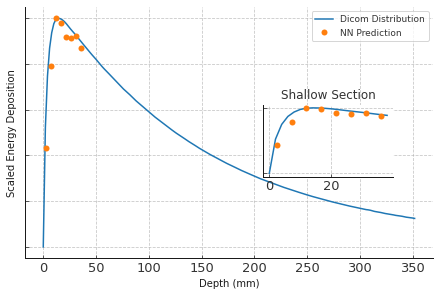

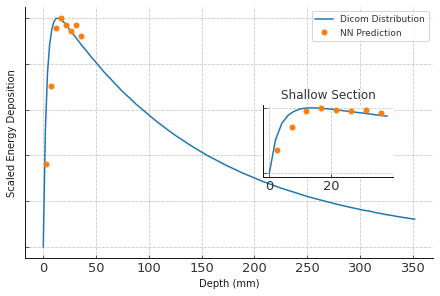

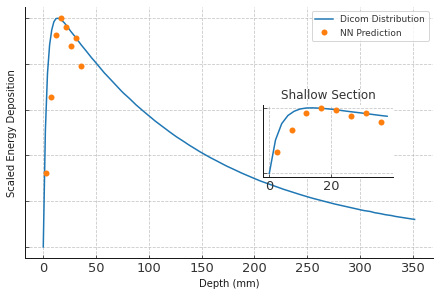

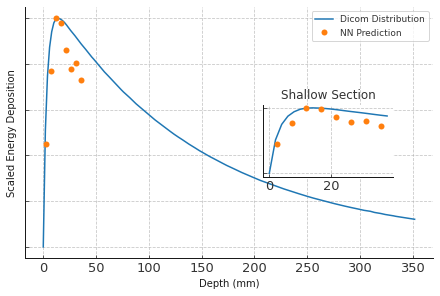

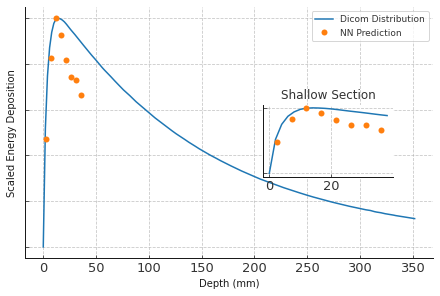

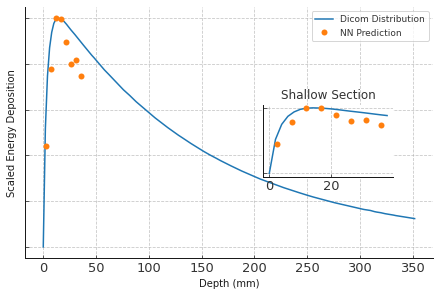

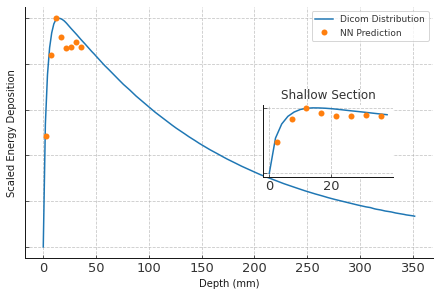

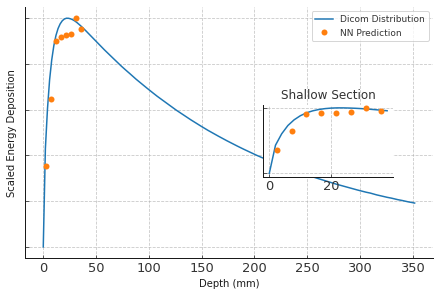

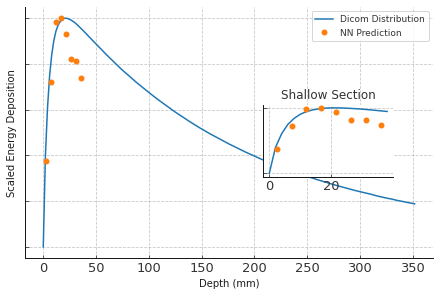

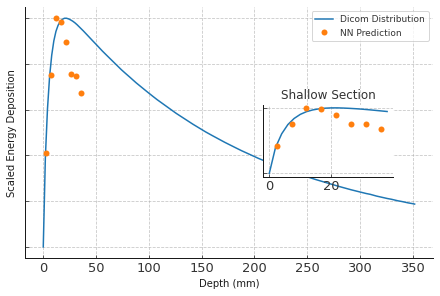

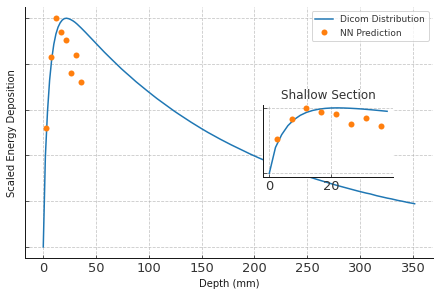

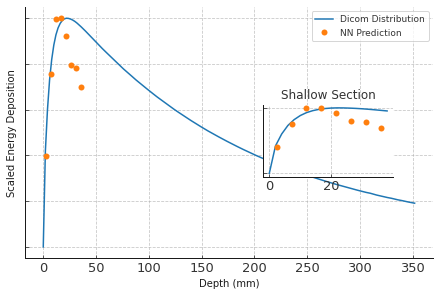

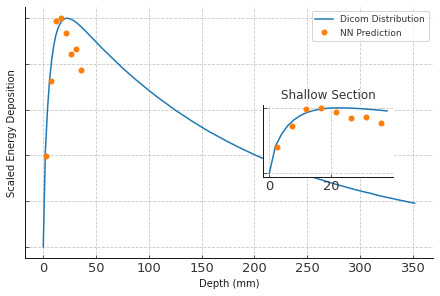

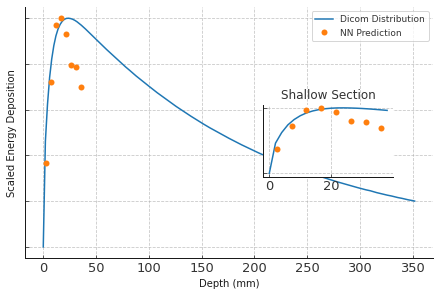

In [20]:
plt.style.use('plotting_style_sheet.txt')

ai_xaxis = gen_ai_axis()

for dicom_file, ohio_file, error_array in zip(dicom_files, ohio_cleaning(ohio_files), complete_error):
    df = pd.read_csv(dicom_file)
    fig = plt.figure(facecolor='white', constrained_layout=True)
    
    _1, energy, size, _2 = os.path.basename(dicom_file).split('_')
    title_info = f"{os.path.basename(ohio_file.rstrip('.txt|'))} {size} {energy}"
    #plt.title(title_info)
    
    plt.ylabel('Scaled Energy Deposition')
    plt.xlabel('Depth (mm)')
    
    plt.plot(df['Distance_(mm)'].values,
             normalize(df['Gray_Value'].values),
             #color="indigo",
             label='Dicom Distribution'
            )
    
    ohio_ydata = np.flip(normalize(ohio_energy_finder(ohio_file)))
    plt.errorbar(ai_xaxis,
                 ohio_ydata,
                 #yerr=error_array * ohio_ydata,
                 ls='',
                 label='NN Prediction',
                 marker='o'
                )
    
    ax = plt.gca()
    ax.set_yticklabels([])
    
    # Sub Plot section
    sub_axes = plt.axes([.6, .4, .3, .25])
    sub_axes.set_yticklabels([])
    sub_axes.set_title('Shallow Section')
    
    zoom_dicom = sub_axes.plot(df['Distance_(mm)'].values[:20],  normalize(df['Gray_Value'].values[:20]))
    
    zoom_error_line = sub_axes.errorbar(ai_xaxis, 
                                        ohio_ydata, 
                                        #yerr=error_array*ohio_ydata , 
                                        label='Neural Net Predictions',
                                        ls='', 
                                        marker = 'o')

    
    ax.legend(prop={'size':9})
    filename = '../figures/nn2DicomComp/FullWaterWithZoom/' + 'plot' + title_info.replace(' ', '_') + '.pdf'
    #print(filename)
    fig.savefig(filename)
    #plt.close()